# Noctunro of Myra's Marvels - Most Common Words

## Import Packages and Data

In [1]:
# packages
from pattern.text.en import singularize
from collections import defaultdict
import nltk
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# data
scryfall = pd.read_json("data/oracle-cards-20220925090228.json")

## Tidy

In [3]:
scryfall.columns

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id',
       'mtgo_foil_id', 'tcgplayer_id', 'cardmarket_id', 'name', 'lang',
       'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image',
       'image_status', 'image_uris', 'mana_cost', 'cmc', 'type_line',
       'oracle_text', 'colors', 'color_identity', 'keywords', 'legalities',
       'games', 'reserved', 'foil', 'nonfoil', 'finishes', 'oversized',
       'promo', 'reprint', 'variation', 'set_id', 'set', 'set_name',
       'set_type', 'set_uri', 'set_search_uri', 'scryfall_set_uri',
       'rulings_uri', 'prints_search_uri', 'collector_number', 'digital',
       'rarity', 'flavor_text', 'card_back_id', 'artist', 'artist_ids',
       'illustration_id', 'border_color', 'frame', 'full_art', 'textless',
       'booster', 'story_spotlight', 'edhrec_rank', 'prices', 'related_uris',
       'security_stamp', 'preview', 'power', 'toughness', 'penny_rank',
       'arena_id', 'watermark', 'produced_mana', 'all_parts', 'ca

In [4]:
cols = ['name', 'colors', 'color_identity', 'oracle_text']
scryfall2 = scryfall[cols]

In [5]:
df = scryfall2

## Slice DataFrame

In [6]:
# slice dataframes

## mono black
mono_black = df
mono_black['match'] = mono_black['color_identity'].apply(lambda x: bool(set(x).intersection('B')))
mono_black = mono_black[(mono_black['match'] == True) & (~mono_black['oracle_text'].isna())].reset_index().drop('index', axis = 1)

## BW
bw = df
bw['match'] = bw['color_identity'].apply(lambda x: bool(set(x).intersection('B') | set(x).intersection('W')))
bw = bw[(bw['match'] == True) & (~bw['oracle_text'].isna())].reset_index().drop('index', axis = 1)

## BU
bu = df
bu['match'] = bu['color_identity'].apply(lambda x: bool(set(x).intersection('B') | set(x).intersection('U')))
bu = bu[(bu['match'] == True) & (~bu['oracle_text'].isna())].reset_index().drop('index', axis = 1)

## BR
br = df
br['match'] = br['color_identity'].apply(lambda x: bool(set(x).intersection('B') | set(x).intersection('R')))
br = br[(br['match'] == True) & (~br['oracle_text'].isna())].reset_index().drop('index', axis = 1)

## BG
bg = df
bg['match'] = bg['color_identity'].apply(lambda x: bool(set(x).intersection('B') | set(x).intersection('G')))
bg = bg[(bg['match'] == True) & (~bg['oracle_text'].isna())].reset_index().drop('index', axis = 1)

C:\Users\nccru\AppData\Local\Temp/ipykernel_6744/4217398.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono_black['match'] = mono_black['color_identity'].apply(lambda x: bool(set(x).intersection('B')))
C:\Users\nccru\AppData\Local\Temp/ipykernel_6744/4217398.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bw['match'] = bw['color_identity'].apply(lambda x: bool(set(x).intersection('B') | set(x).intersection('W')))
C:\Users\nccru\AppData\Local\Temp/ipykernel_6744/4217398.py:15: SettingWithCopyWarni

## Get Word Counts By Color Identity

In [7]:
def get_word_counts(df):
    """
    Takes a dataframe of oracle texts matching a particular commander color identity and returns words with more than 5 letters and the number of cards they show up in (sorted in descending order).
    """
    words = defaultdict(int)
    for card in df.itertuples():
        # extract oracle text and clean it up
        o = card.oracle_text
        o = re.sub(r'\{[A-Z0-9]\}', '', o)
        o = ''.join([c.lower() for c in o if c.isalpha() or c.isspace()]).split()

        # add to count of words if number of unique letters is greater than 5
        for word in set(o):
            if len(word) >= 5:
                words[word] += 1
                
    # construct it as a dataframe
    counts = pd.DataFrame({'word': words.keys(), 'count': words.values()})

    # add part of speech and singularize plurals
    # counts['word'] = counts['word'].apply(lambda x: singularize(x))
    # counts = counts.groupby('word').agg({'count': 'sum'}).reset_index()
    counts['pos'] = nltk.pos_tag(counts['word'])
    counts['pos'] = counts['pos'].apply(lambda x: x[1])
    counts['Part Of Speech'] = np.select(
        [
            counts['pos'].isin(['NN', 'NNS', 'NNP', 'NNPS']),
            counts['pos'].isin(['RB', 'RBR', 'RBS', 'WRB']),
            counts['pos'].isin(['JJ', 'JJR', 'JJS']),
            counts['pos'].isin(['VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ']),
            counts['pos'].str.contains('IN'),
        ],
        [
            'Noun',
            'Adverb',
            'Adjective',
            'Verb',
            'Preposition'
        ]
    )

    # sort valeus
    counts = counts[(counts['count'] >= 50)].sort_values(by = 'count', ascending = False)
    
    return counts

In [8]:
# transform the dataframes as specified above
count_b = get_word_counts(mono_black)
count_bw = get_word_counts(bw)
count_bu = get_word_counts(bu)
count_br = get_word_counts(br)
count_bg = get_word_counts(bg)

## Plot Top 25 Words

In [20]:
def plot_top_words(df, main_title, save_image = True):
    fig = plt.figure(figsize = (8,12))
    fig = sns.set_theme(style = 'white', font_scale = 1.2)
    fig = sns.barplot(
        data = df.head(25),
        x = 'count', y = 'word',
        hue = 'Part Of Speech', dodge = False
    ).set(
        title = "Nocturno of Myra's Marvels - {}\nTop 25 Words With More Than 5 Letters That Appear In Rules Text".format(main_title),
        xlabel = 'Number of Unique Cards',
        ylabel = ''
    )
    
    if save_image == True:
        plt.savefig('images/Nocturno - {} Top Words.png'.format(main_title), bbox_inches = 'tight')

    return fig

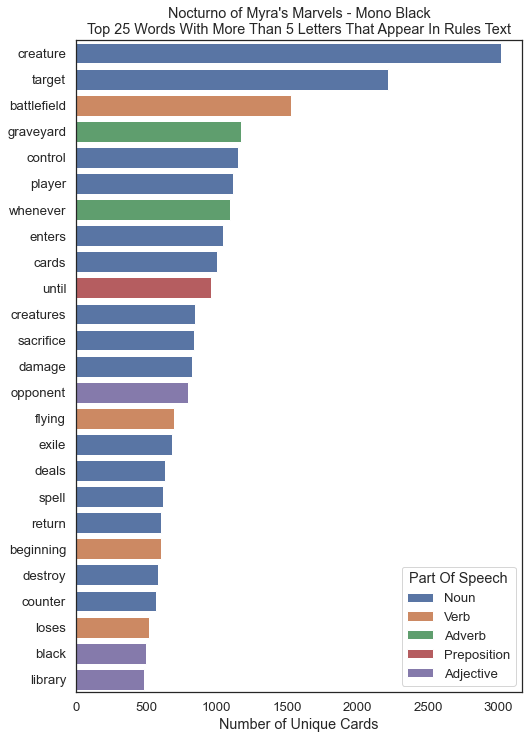

In [10]:
# plot Mono Black
plot_b = plot_top_words(count_b, 'Mono Black')
plot_b;

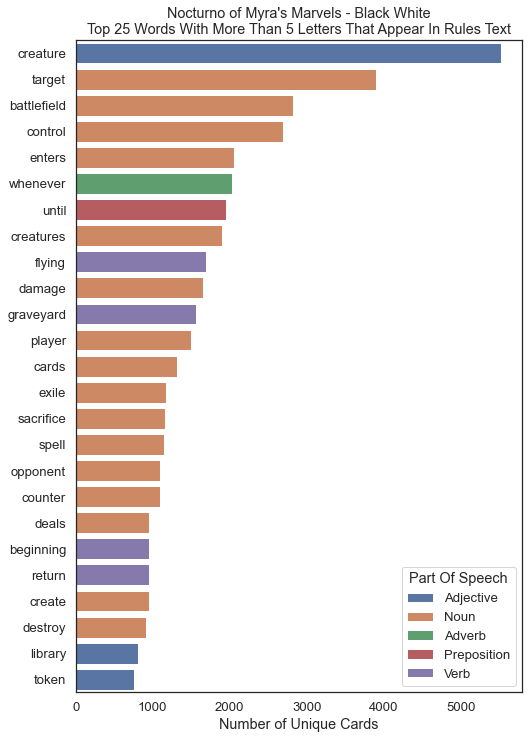

In [11]:
# plot BW
plot_bw = plot_top_words(count_bw, 'Black White')
plot_bw;

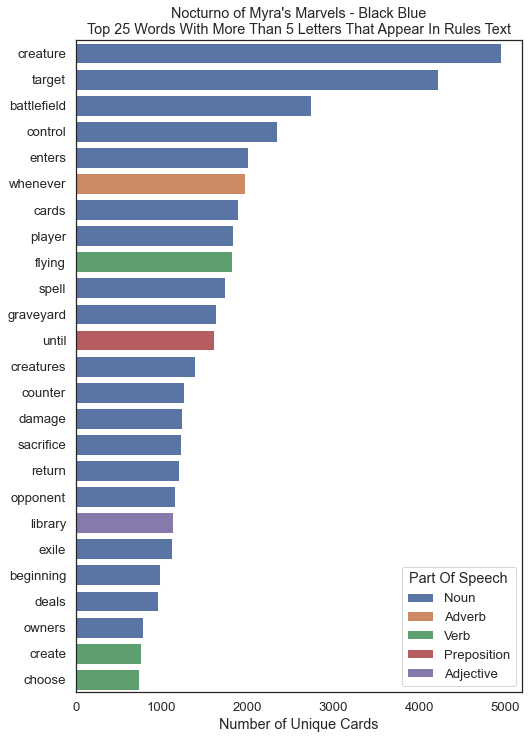

In [12]:
# plot BU
plot_bu = plot_top_words(count_bu, 'Black Blue')
plot_bu;

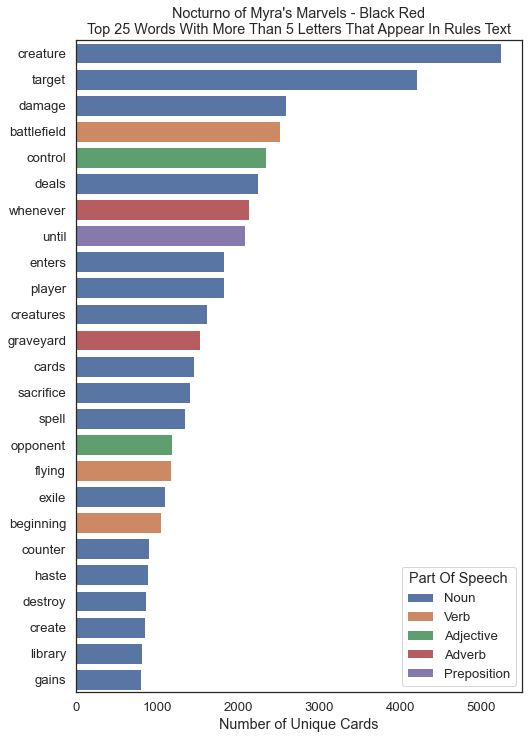

In [13]:
# plot BR
plot_br = plot_top_words(count_br, 'Black Red')
plot_br;

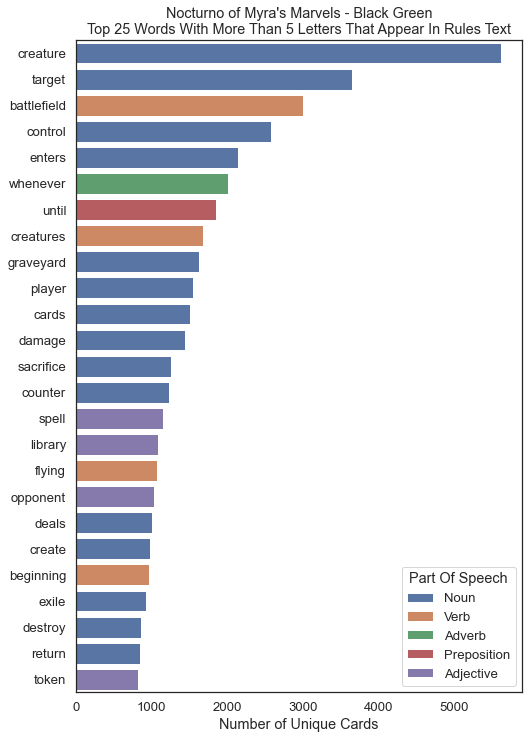

In [14]:
# plot BG
plot_bg = plot_top_words(count_bg, 'Black Green')
plot_bg;

## Get Strangest Words With Enough Cards

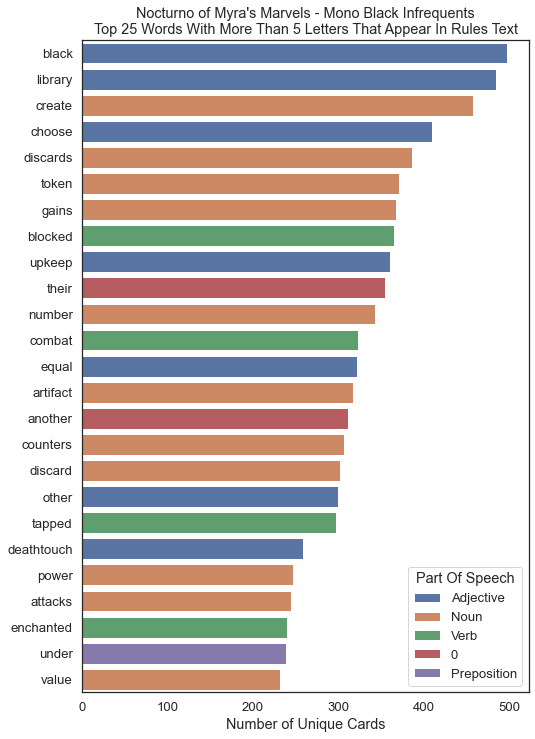

In [24]:
plot_top_words(count_b[(count_b['count'] >= 200) & (count_b['count'] <= 500)], 'Mono Black Infrequents', save_image = True);